<a href="https://colab.research.google.com/github/bewww831/bewww831.github.io/blob/main/Amazon_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install yfinance

In [2]:
import requests
import pandas as pd
from io import StringIO
import yfinance as yf
import warnings
warnings.filterwarnings('ignore')

In [21]:
data = yf.download("AMZN", start="2019-01-01", end="2025-11-01")
df = data[["Open", "High", "Low", "Close", "Volume"]].copy()
df['daily_return'] = df['Close'].pct_change()
df['ma7']  = df['Close'].rolling(window=7).mean()
df['ma30'] = df['Close'].rolling(window=30).mean()
df['volatility_14d'] = df['daily_return'].rolling(window=14).std()
df = df.dropna()
df.reset_index(inplace=True)
df.head()

[*********************100%***********************]  1 of 1 completed


Price,Date,Open,High,Low,Close,Volume,daily_return,ma7,ma30,volatility_14d
Ticker,,AMZN,AMZN,AMZN,AMZN,AMZN,,,,
0,2019-02-13,82.349998,82.819000,81.855499,82.000000,71206000,0.001215,81.219072,81.784816,0.026324
1,2019-02-14,81.224998,81.894997,80.303001,81.132500,82410000,-0.010579,80.960786,81.924017,0.026296
2,2019-02-15,81.392998,81.445503,80.224998,80.397499,86878000,-0.009059,80.730000,82.103467,0.025896
3,2019-02-19,80.050003,81.699997,80.028000,81.378998,73634000,0.012208,80.824357,82.190450,0.024984
4,2019-02-20,81.500000,81.746498,80.505997,81.105003,66752000,-0.003367,81.066357,82.178100,0.021148


In [22]:
df.columns = df.columns.droplevel(1)
df.head()

Price,Date,Open,High,Low,Close,Volume,daily_return,ma7,ma30,volatility_14d
0,2019-02-13,82.349998,82.819000,81.855499,82.000000,71206000,0.001215,81.219072,81.784816,0.026324
1,2019-02-14,81.224998,81.894997,80.303001,81.132500,82410000,-0.010579,80.960786,81.924017,0.026296
2,2019-02-15,81.392998,81.445503,80.224998,80.397499,86878000,-0.009059,80.730000,82.103467,0.025896
3,2019-02-19,80.050003,81.699997,80.028000,81.378998,73634000,0.012208,80.824357,82.190450,0.024984
4,2019-02-20,81.500000,81.746498,80.505997,81.105003,66752000,-0.003367,81.066357,82.178100,0.021148


In [23]:
print(df["Date"].dtype)

datetime64[ns]


In [24]:
df.index = df.pop('Date')
df

Price,Open,High,Low,Close,Volume,daily_return,ma7,ma30,volatility_14d
Date,,,,,,,,,
2019-02-13,82.349998,82.819000,81.855499,82.000000,71206000,0.001215,81.219072,81.784816,0.026324
2019-02-14,81.224998,81.894997,80.303001,81.132500,82410000,-0.010579,80.960786,81.924017,0.026296
2019-02-15,81.392998,81.445503,80.224998,80.397499,86878000,-0.009059,80.730000,82.103467,0.025896
2019-02-19,80.050003,81.699997,80.028000,81.378998,73634000,0.012208,80.824357,82.190450,0.024984
2019-02-20,81.500000,81.746498,80.505997,81.105003,66752000,-0.003367,81.066357,82.178100,0.021148
...,...,...,...,...,...,...,...,...,...
2025-10-27,227.660004,228.399994,225.539993,226.970001,38267000,0.012310,220.252856,221.981000,0.020156
2025-10-28,228.220001,231.490005,226.210007,229.250000,47100000,0.010045,222.568571,221.821000,0.019923
2025-10-29,231.669998,232.820007,227.759995,230.300003,52036200,0.004580,224.542858,221.777000,0.019752


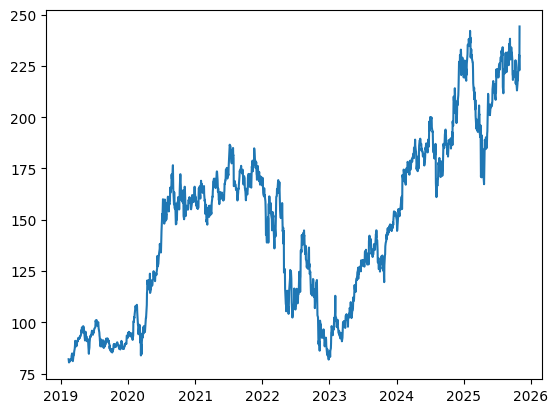

In [25]:
import matplotlib.pyplot as plt

plt.plot(df.index, df['Close'])

In [8]:
feature_cols = [
    "Open", "High", "Low", "Close", "Volume",
    "daily_return", "ma7", "ma30", "volatility_14d"
]
X = df[feature_cols].values
y = df['Close'].values

In [26]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_lstm = X_scaled.reshape(X_scaled.shape[0], 1, X_scaled.shape[1])

split1 = int(len(X_lstm) * 0.7)
split2 = int(len(X_lstm) * 0.9)

X_train, y_train = X_lstm[:split1], y[:split1]
X_val, y_val     = X_lstm[split1:split2], y[split1:split2]
X_test, y_test   = X_lstm[split2:], y[split2:]

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam

model = Sequential([
    layers.Input((1, len(feature_cols))),   # (timesteps=1, features=9)
    layers.LSTM(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])

model.compile(
    loss='mse',
    optimizer=Adam(0.001),
    metrics=['mae']
)

model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 64)             │        18,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,113 (86.38 KB)

 Trainable params: 22,113 (86.38 KB)

 Non-trainable params: 0 (0.00 B)

In [28]:
history_64 = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32
)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 17247.4883 - mae: 127.7271 - val_loss: 34088.8125 - val_mae: 182.8345
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 16884.9102 - mae: 126.2948 - val_loss: 29774.1035 - val_mae: 170.9851
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 13544.5674 - mae: 113.1225 - val_loss: 10174.4463 - val_mae: 100.6114
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3825.7290 - mae: 57.7649 - val_loss: 2350.3113 - val_mae: 39.4241
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 521.3181 - mae: 19.7688 - val_loss: 863.6339 - val_mae: 22.6550
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 382.2460 - mae: 16.0998 - val_loss: 860.1533 - val_mae: 22.8146
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 333.5299 - mae: 15.0418 - val_loss: 625.4109 - val_mae: 19.0979
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 280.5142 - mae: 13.8627 - val_loss: 558.8681 - val_mae: 18.0636
Epo

In [35]:
model.evaluate(X_test, y_test)
preds = model.predict(X_test).flatten()
test_dates = df.index[split2:]   # same split as X_test, y_test
dates = df.index

dates_train = dates[:split1]
dates_val   = dates[split1:split2]
dates_test  = dates[split2:]

train_predictions = model.predict(X_train).flatten()
val_predictions   = model.predict(X_val).flatten()
test_predictions  = model.predict(X_test).flatten()

split1 = int(len(X_lstm) * 0.7)
split2 = int(len(X_lstm) * 0.9)

X_train, y_train = X_lstm[:split1], y[:split1]
X_val,   y_val   = X_lstm[split1:split2], y[split1:split2]
X_test,  y_test  = X_lstm[split2:], y[split2:]

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Predict
y_pred = model.predict(X_test).flatten()

# Metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)

# Print nicely
print(f"MAE  : {mae:.4f}")
print(f"MSE  : {mse:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"R²   : {r2:.4f}")


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 78.9954 - mae: 7.8969
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
MAE  : 9.7859
MSE  : 115.9050
RMSE : 10.7659
R²   : 0.5976


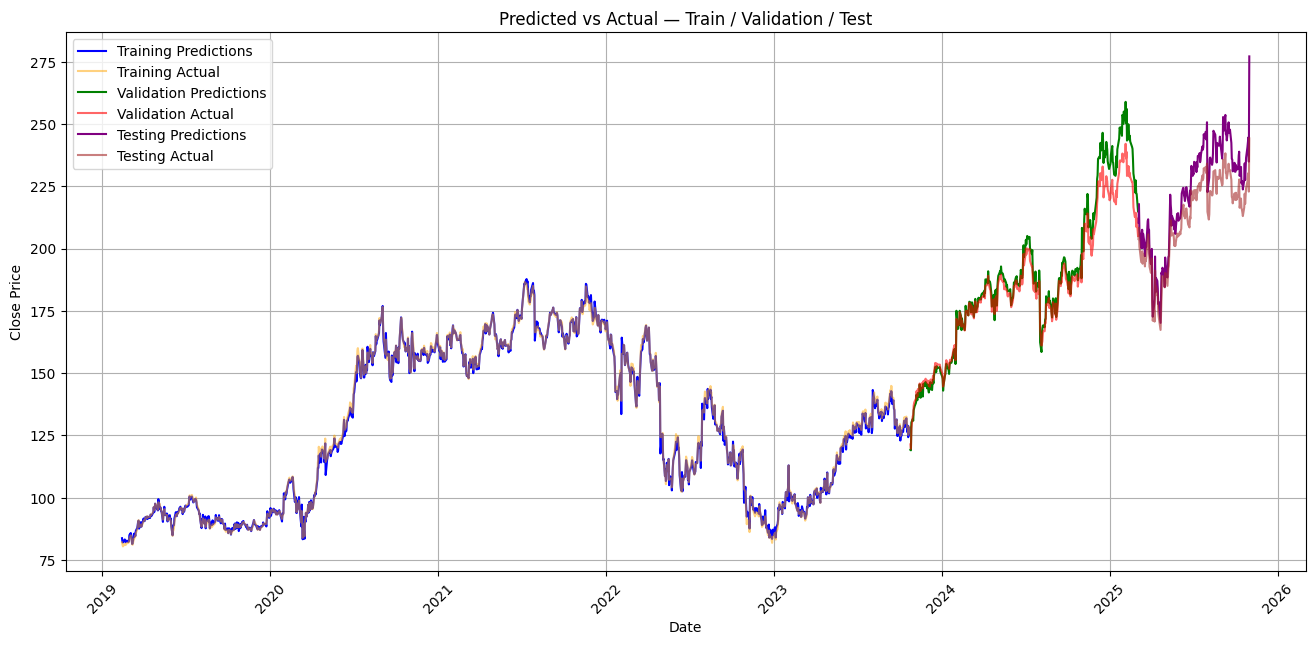

In [36]:
plt.figure(figsize=(16,7))

# Training
plt.plot(dates_train, train_predictions, color='blue', label='Training Predictions')
plt.plot(dates_train, y_train, color='orange', alpha=0.5, label='Training Actual')

# Validation
plt.plot(dates_val, val_predictions, color='green', label='Validation Predictions')
plt.plot(dates_val, y_val, color='red', alpha=0.6, label='Validation Actual')

# Testing
plt.plot(dates_test, test_predictions, color='purple', label='Testing Predictions')
plt.plot(dates_test, y_test, color='brown', alpha=0.6, label='Testing Actual')

plt.title("Predicted vs Actual — Train / Validation / Test")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

plt.show()


In [40]:
model = Sequential([
    layers.Input((1, len(feature_cols))),   # (timesteps=1, features=9)
    layers.LSTM(128, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])

model.compile(
    loss='mse',
    optimizer=Adam(0.001),
    metrics=['mae']
)

model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 128)            │        70,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,873 (296.38 KB)

 Trainable params: 75,873 (296.38 KB)

 Non-trainable params: 0 (0.00 B)

In [41]:
history_128 = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32
)

Epoch 1/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 17113.3359 - mae: 127.0554 - val_loss: 34320.0430 - val_mae: 183.4516
Epoch 2/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 17637.1641 - mae: 129.0806 - val_loss: 31732.7109 - val_mae: 176.4652
Epoch 3/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 14957.8623 - mae: 118.9180 - val_loss: 16863.1172 - val_mae: 129.1898
Epoch 4/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6809.1445 - mae: 79.1763 - val_loss: 762.8023 - val_mae: 20.8556
Epoch 5/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 532.2511 - mae: 19.7086 - val_loss: 1118.6473 - val_mae: 26.2970
Epoch 6/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 431.0258 - mae: 17.1831 - val_loss: 949.0259 - val_mae: 24.0670
Epoch 7/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 372.5578 - mae: 15.9546 - val_loss: 703.2030 - val_mae: 20.3252
Epoch 8/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 348.1973 - mae: 15.4447 - val_loss: 591.0089 - val_mae: 18.

In [42]:
# Predict
y_pred = model.predict(X_test).flatten()

# Metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)

# Print nicely
print(f"MAE  : {mae:.4f}")
print(f"MSE  : {mse:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"R²   : {r2:.4f}")


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
MAE  : 8.9885
MSE  : 106.4139
RMSE : 10.3157
R²   : 0.6306


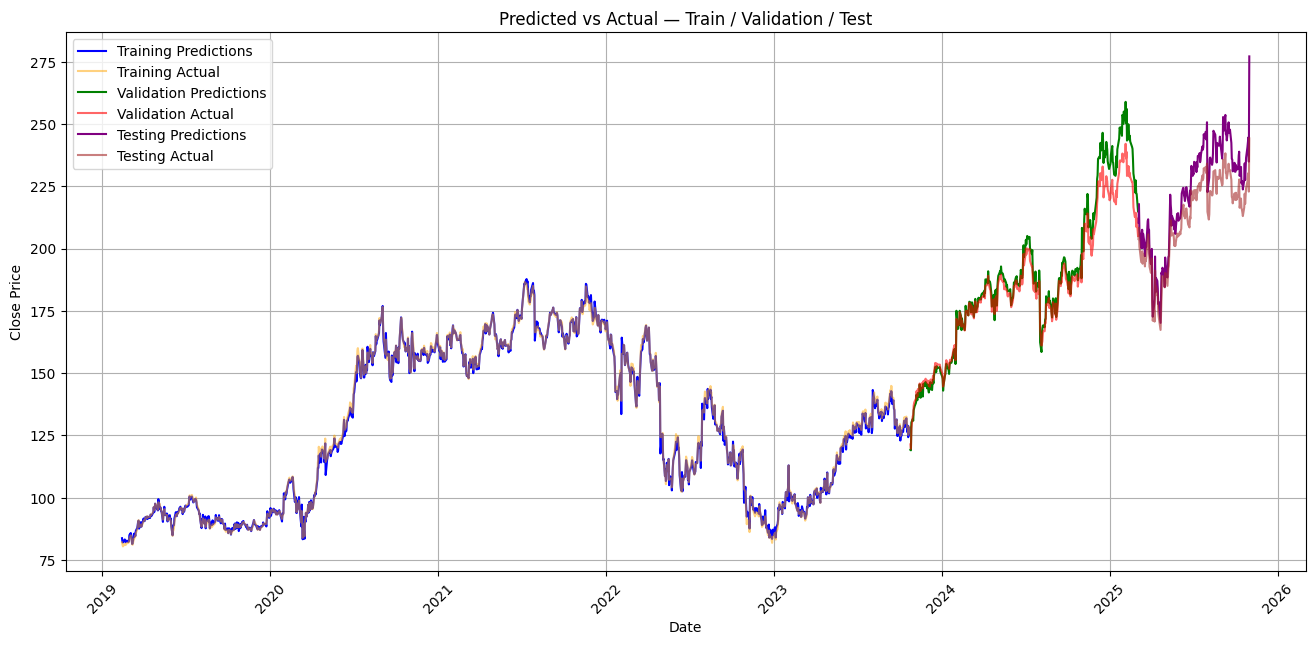

In [43]:
plt.figure(figsize=(16,7))

# Training
plt.plot(dates_train, train_predictions, color='blue', label='Training Predictions')
plt.plot(dates_train, y_train, color='orange', alpha=0.5, label='Training Actual')

# Validation
plt.plot(dates_val, val_predictions, color='green', label='Validation Predictions')
plt.plot(dates_val, y_val, color='red', alpha=0.6, label='Validation Actual')

# Testing
plt.plot(dates_test, test_predictions, color='purple', label='Testing Predictions')
plt.plot(dates_test, y_test, color='brown', alpha=0.6, label='Testing Actual')

plt.title("Predicted vs Actual — Train / Validation / Test")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

plt.show()


In [44]:
data = yf.download("AMZN", start="2019-01-01", end="2025-11-01")

df1 = data[["Open", "High", "Low", "Close", "Volume"]].copy()

# --- Existing features ---
df1['daily_return'] = df1['Close'].pct_change()
df1['ma7']  = df1['Close'].rolling(window=7).mean()
df1['ma30'] = df1['Close'].rolling(window=30).mean()
df1['volatility_14d'] = df1['daily_return'].rolling(window=14).std()

# --- NEW: EMA (Exponential Moving Averages) ---
df1['ema12'] = df1['Close'].ewm(span=12, adjust=False).mean()   # fast EMA
df1['ema26'] = df1['Close'].ewm(span=26, adjust=False).mean()   # slow EMA
df1['ema9']  = df1['Close'].ewm(span=9, adjust=False).mean()    # shorter EMA

# --- NEW: MACD (12, 26, 9) ---
df1['macd'] = df1['ema12'] - df1['ema26']                       # MACD line
df1['macd_signal'] = df1['macd'].ewm(span=9, adjust=False).mean() # Signal line
df1['macd_hist']   = df1['macd'] - df1['macd_signal']             # Histogram

# Clean NaN rows
df1 = df1.dropna()

# Reset index if needed
df1.reset_index(inplace=True)

df1.columns = df1.columns.droplevel(1)
df1.index = df1.pop('Date')

df1.head()


[*********************100%***********************]  1 of 1 completed


Price,Open,High,Low,Close,Volume,daily_return,ma7,ma30,volatility_14d,ema12,ema26,ema9,macd,macd_signal,macd_hist
Date,,,,,,,,,,,,,,,
2019-02-13,82.349998,82.819000,81.855499,82.000000,71206000,0.001215,81.219072,81.784816,0.026324,81.553730,81.340115,81.452457,0.213615,0.536542,-0.322927
2019-02-14,81.224998,81.894997,80.303001,81.132500,82410000,-0.010579,80.960786,81.924017,0.026296,81.488925,81.324736,81.388466,0.164189,0.462072,-0.297882
2019-02-15,81.392998,81.445503,80.224998,80.397499,86878000,-0.009059,80.730000,82.103467,0.025896,81.321014,81.256052,81.190273,0.064962,0.382650,-0.317688
2019-02-19,80.050003,81.699997,80.028000,81.378998,73634000,0.012208,80.824357,82.190450,0.024984,81.329934,81.265159,81.228018,0.064775,0.319075,-0.254299
2019-02-20,81.500000,81.746498,80.505997,81.105003,66752000,-0.003367,81.066357,82.178100,0.021148,81.295329,81.253296,81.203415,0.042034,0.263667,-0.221633


In [45]:
feature_cols = [
    "Open",
    "High",
    "Low",
    "Close",
    "Volume",
    "daily_return",
    "ma7",
    "ma30",
    "volatility_14d",
    "ema12",
    "ema26",
    "ema9",
    "macd",
    "macd_signal",
    "macd_hist"
]

X = df1[feature_cols].values
y = df1["Close"].values

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

X_lstm = X_scaled.reshape(X_scaled.shape[0], 1, X_scaled.shape[1])

split1 = int(len(X_lstm) * 0.7)
split2 = int(len(X_lstm) * 0.9)

X_train, y_train = X_lstm[:split1], y[:split1]
X_val, y_val     = X_lstm[split1:split2], y[split1:split2]
X_test, y_test   = X_lstm[split2:], y[split2:]


In [46]:
model = Sequential([
    layers.Input((1, len(feature_cols))),   # (timesteps=1, features=9)
    layers.LSTM(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])

model.compile(
    loss='mse',
    optimizer=Adam(0.001),
    metrics=['mae']
)

model.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 64)             │        20,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,649 (92.38 KB)

 Trainable params: 23,649 (92.38 KB)

 Non-trainable params: 0 (0.00 B)

In [47]:
history_15cols = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32
)

Epoch 1/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 17375.8359 - mae: 128.0207 - val_loss: 34099.7227 - val_mae: 182.8634
Epoch 2/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 16749.4355 - mae: 125.7012 - val_loss: 29181.2539 - val_mae: 169.3036
Epoch 3/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 12914.9424 - mae: 110.3520 - val_loss: 5904.0088 - val_mae: 76.6941
Epoch 4/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2214.1226 - mae: 42.8437 - val_loss: 2040.8596 - val_mae: 37.6893
Epoch 5/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 362.9537 - mae: 16.3301 - val_loss: 934.0693 - val_mae: 23.2948
Epoch 6/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 283.5568 - mae: 14.2544 - val_loss: 629.9011 - val_mae: 18.4423
Epoch 7/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 233.6863 - mae: 13.0115 - val_loss: 582.6961 - val_mae: 17.8335
Epoch 8/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 184.0807 - mae: 11.2730 - val_loss: 430.5618 - val_mae: 15.06

In [48]:
# Predict
y_pred = model.predict(X_test).flatten()

# Metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)

# Print nicely
print(f"MAE  : {mae:.4f}")
print(f"MSE  : {mse:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"R²   : {r2:.4f}")


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 155ms/step
MAE  : 6.5290
MSE  : 50.9173
RMSE : 7.1356
R²   : 0.8232


In [51]:
model = Sequential([
    layers.Input((1, len(feature_cols))),   # (timesteps=1, features=9)
    layers.LSTM(128, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])

model.compile(
    loss='mse',
    optimizer=Adam(0.001),
    metrics=['mae']
)

model.summary()


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_5 (LSTM)                   │ (None, 128)            │        73,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 78,945 (308.38 KB)

 Trainable params: 78,945 (308.38 KB)

 Non-trainable params: 0 (0.00 B)

In [52]:
history_15cols128 = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32
)

Epoch 1/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 17631.4785 - mae: 129.1109 - val_loss: 33834.5781 - val_mae: 182.1553
Epoch 2/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 16624.1641 - mae: 125.1581 - val_loss: 24281.2051 - val_mae: 154.6111
Epoch 3/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 9964.6230 - mae: 95.8081 - val_loss: 439.3401 - val_mae: 15.3792
Epoch 4/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 463.7991 - mae: 18.2312 - val_loss: 791.9911 - val_mae: 20.5865
Epoch 5/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 331.0495 - mae: 15.5439 - val_loss: 757.1663 - val_mae: 20.0673
Epoch 6/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 249.1792 - mae: 13.3754 - val_loss: 700.7580 - val_mae: 19.3806
Epoch 7/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 202.0487 - mae: 11.8562 - val_loss: 473.2923 - val_mae: 15.5678
Epoch 8/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 169.4623 - mae: 10.6766 - val_loss: 344.3219 - val_mae: 13.1857
Ep

In [53]:
# Predict
y_pred = model.predict(X_test).flatten()

# Metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)

# Print nicely
print(f"MAE  : {mae:.4f}")
print(f"MSE  : {mse:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"R²   : {r2:.4f}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step
MAE  : 2.6964
MSE  : 10.0775
RMSE : 3.1745
R²   : 0.9650


In [54]:
model = Sequential([
    layers.Input((1, len(feature_cols))),   # (timesteps=1, features=9)
    layers.GRU(128, activation='relu', return_sequences=False),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])

model.compile(
    loss='mse',
    optimizer=Adam(0.001),
    metrics=['mae']
)

model.summary()


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 128)            │        55,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66,049 (258.00 KB)

 Trainable params: 66,049 (258.00 KB)

 Non-trainable params: 0 (0.00 B)

In [55]:
history_GRU = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32
)

Epoch 1/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 17427.5254 - mae: 128.2540 - val_loss: 33576.7461 - val_mae: 181.4587
Epoch 2/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 16152.6875 - mae: 123.5745 - val_loss: 22188.1816 - val_mae: 147.6833
Epoch 3/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 8181.3442 - mae: 85.8386 - val_loss: 115.8002 - val_mae: 7.9682
Epoch 4/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 163.9797 - mae: 10.3760 - val_loss: 113.5522 - val_mae: 7.8271
Epoch 5/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 99.8673 - mae: 8.3711 - val_loss: 155.4361 - val_mae: 9.0723
Epoch 6/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 84.9049 - mae: 7.6640 - val_loss: 135.3132 - val_mae: 8.4549
Epoch 7/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 78.2195 - mae: 7.1871 - val_loss: 109.8418 - val_mae: 7.6158
Epoch 8/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 63.5234 - mae: 6.4460 - val_loss: 83.5198 - val_mae: 6.8048
Epoch 9/100
37/37

In [56]:
# Predict
y_pred = model.predict(X_test).flatten()

# Metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)

# Print nicely
print(f"MAE  : {mae:.4f}")
print(f"MSE  : {mse:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"R²   : {r2:.4f}")


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step
MAE  : 2.0468
MSE  : 7.1241
RMSE : 2.6691
R²   : 0.9753


In [57]:
pip install xgboost

In [58]:
X = df1[feature_cols].values
y = df1["Close"].values

n = len(X)
split1 = int(n * 0.7)   # 70% train
split2 = int(n * 0.9)   # 20% val, 10% test

X_train, y_train = X[:split1], y[:split1]
X_val,   y_val   = X[split1:split2], y[split1:split2]
X_test,  y_test  = X[split2:], y[split2:]

In [59]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

xgb_model = XGBRegressor(
    n_estimators=500,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    tree_method="hist",
    random_state=42
)

# FIT WITH NO eval_set & NO early_stopping
xgb_model.fit(X_train, y_train)

# Predict
y_pred_xgb = xgb_model.predict(X_test)

# Metrics
mse  = mean_squared_error(y_test, y_pred_xgb)
mae  = mean_absolute_error(y_test, y_pred_xgb)
rmse = mse ** 0.5
r2   = r2_score(y_test, y_pred_xgb)

print("XGBoost results:")
print(f"MAE  : {mae:.4f}")
print(f"MSE  : {mse:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"R²   : {r2:.4f}")


XGBoost results:
MAE  : 27.8666
MSE  : 1018.2358
RMSE : 31.9098
R²   : -2.5350
